**Importing Libraries and Setting Up Figure Style**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import ML
import lightgbm as lgb #gradient boosted decsion tree machine
from sklearn.model_selection import KFold ,train_test_split  
from sklearn.metrics import mean_squared_error #metrics
import pickle #to export our ML model
from scipy import stats

# set up plot styles
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")


Above we have imported all the modules needed for reading and cleaning the database, data viz and machine learning analysis of the data. We have chosen to use a light gradient boosted machine (lightgbm) to build our model as it has been shown to return models with low mean square error compared to decsion tree, random forest, SVM, kNN.We also set the appreance of plots at this step so our output has a consistent style. This is an important (and often overlooked!) point for convinvcing reports for stakeholders of both technical and non-technical backgrounds.


**Read Data Files into Dataframe**

In [2]:

calendar_df = pd.read_csv('./DS/calendar.csv',parse_dates=['date'])
listings_df = pd.read_csv('./DS/listings.csv')
#reviews_df = pd.read_csv('./DS/reviews.csv') #not useful w/o NLP-sentiment analysis

calendar_df.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Firstly, we should determine how many missing entries/NAN in each of the columns. We also need to clean the data by converting 'available' column entries to logic 0 or 1 instead of 'f' and 't' and then stripping dollar signs and commas from 'price' and force it as a float. 

In [3]:
calendar_df['available'] = calendar_df['available'].map({'f':0,'t':1})
calendar_df['price'] = calendar_df['price'].replace({'\$':'',',':''}, regex = True).astype(float)


calendar_cols_NaN_df = 100*calendar_df.isnull().mean() #NaN % per column

for col in calendar_df:
    if calendar_df[col].isnull().any():
        print('\n  %s column is %0.2f percent "NaN" \n' %(col,calendar_cols_NaN_df[col]))

Available_Price_NaN_df = calendar_df[calendar_df['available']>0]
Available_Price_NaN_mean = Available_Price_NaN_df['price'].isnull().mean()
#booking_mean = calendar_df['available'].mean()          
print('  of which %0.2f percent are available \n' %Available_Price_NaN_mean)
        
calendar_df.head()


  price column is 32.94 percent "NaN" 

  of which 0.00 percent are available 



,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


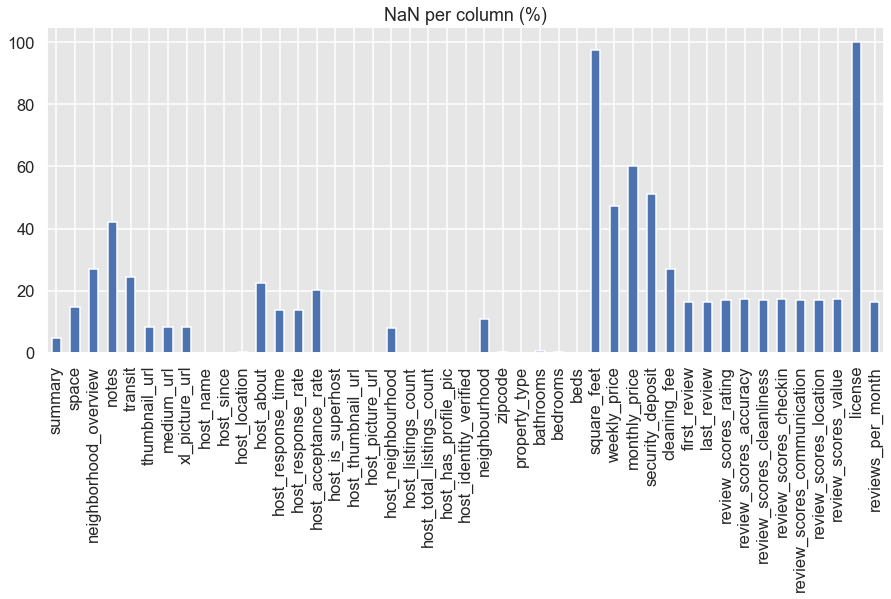

In [4]:
listings_cols_NaN_df = 100*listings_df.isnull().mean()
        
ax1 = listings_cols_NaN_df[listings_cols_NaN_df>0.02].plot.bar(figsize=(15, 6),title='NaN per column (%)') #show columns with >2% NaN entries



Nearly 33% of listings do not list a price (or the scraper failed to find it), but all of these missing values are from listings which are unavailable, and so we do not need to replace the missing data with some method (mean or median price etc). We also see that there several features (columns) in the lisitings database with large amounts (>25%) of missing data, these features will not be useful for traing our machine learning models.

**Exploratory Data Analysis**

Daily price distribution and mean:

Cheapest listing mean price is $20.00 per night
Most Expensive listing mean price is $1301.82 per night
The Average listing mean price is $135.76 per night
The Median listing mean price is $108.42 per night


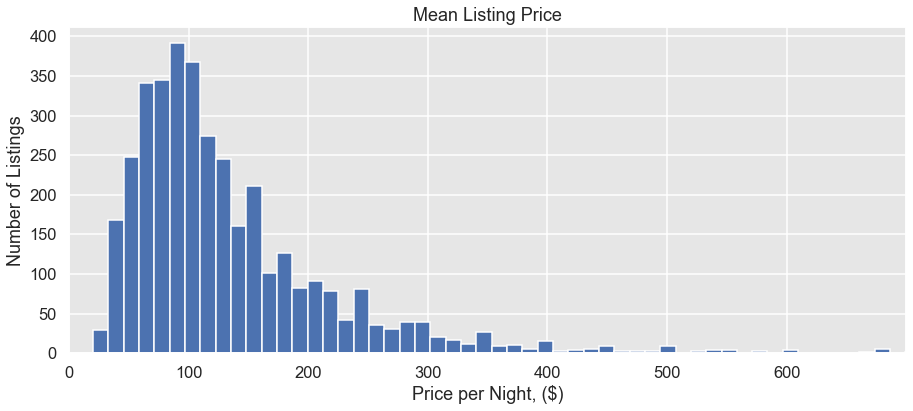

In [5]:
overview_df = calendar_df[calendar_df['available']>0] # unbooked properties with price information 
mean_listing_prices = overview_df.groupby('listing_id')['price'].mean()
print('Cheapest listing mean price is $%0.2f per night' %mean_listing_prices.min())
print('Most Expensive listing mean price is $%0.2f per night' %mean_listing_prices.max())
print('The Average listing mean price is $%0.2f per night' %mean_listing_prices.mean())
print('The Median listing mean price is $%0.2f per night' %mean_listing_prices.median())

#plot mean price distribution
plt.figure(figsize=(15,6))
plt.hist(mean_listing_prices, bins=100)
plt.xticks(np.arange(0, 700, step=100))
plt.xlim((0, 700))
plt.ylabel('Number of Listings')
plt.xlabel('Price per Night, ($)')
plt.title('Mean Listing Price');



**Insights** 

We see that listing prices follow a positive skewed normal distribution with a mean price of \\$135 per night and median price of \\$108 per night. The most expensive listing is \\$1300 a night and the cheapest just \\$20 per night.



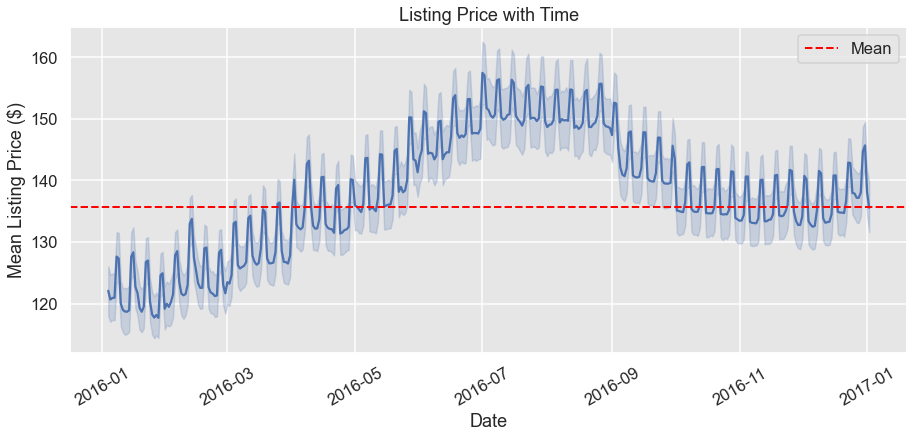

In [6]:
#plot mean price change with time
plt.figure(figsize=(15,6))
ax2 = sns.lineplot(x="date", y="price",markers = True, dashes = False, data = calendar_df[calendar_df['available']>0])
plt.axhline(mean_listing_prices.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.xticks(rotation = 30)
plt.title('Listing Price with Time')
plt.xlabel('Date')
plt.ylabel('Mean Listing Price ($)')
plt.legend(loc='best');

**Insights:**

Mean prices spike each weekend and rise over the year to over \\$150 a night during the summer period. Potential hosts should ensure their property has good availability over this period to maximize returns. 

Availablity of Listings Analysis:

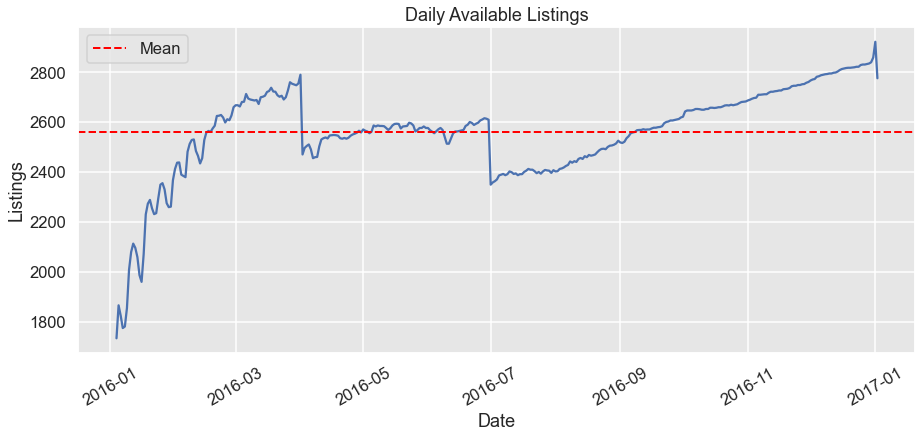

In [7]:
listings_number = calendar_df[calendar_df['available']>0].groupby('date')['listing_id'].nunique()

plt.figure(figsize=(15,6))
plt.plot(listings_number)
plt.axhline(listings_number.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 30)
plt.title('Daily Available Listings')
plt.xlabel('Date')
plt.ylabel('Listings')
plt.legend(loc='best');

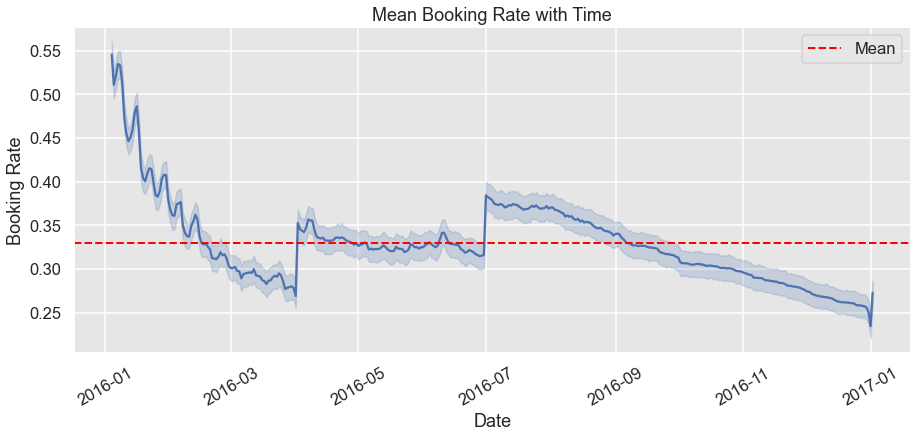

In [8]:
#calculate and plot booking rate

calendar_df['booked'] = abs(calendar_df['available']-1) #if listing is available it is not booked

plt.figure(figsize=(15,6))
ax3 = sns.lineplot(x="date", y="booked",markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['booked'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.xticks(rotation = 30)
plt.title('Mean Booking Rate with Time')
plt.xlabel('Date')
plt.ylabel('Booking Rate')
plt.legend(loc='best');




**Insights** 

We find the number of listings increases across the year from 1800 to 2800 and as a result supply outstrips demand and the mean booking rate per night slumps from 55\% to 25\% with a average across the year of 34\% of listings booked each night. We also see large jumps in the booking rate around holiday weekends (Easter and Independence Day).


**Exploring Feature Correlations:**

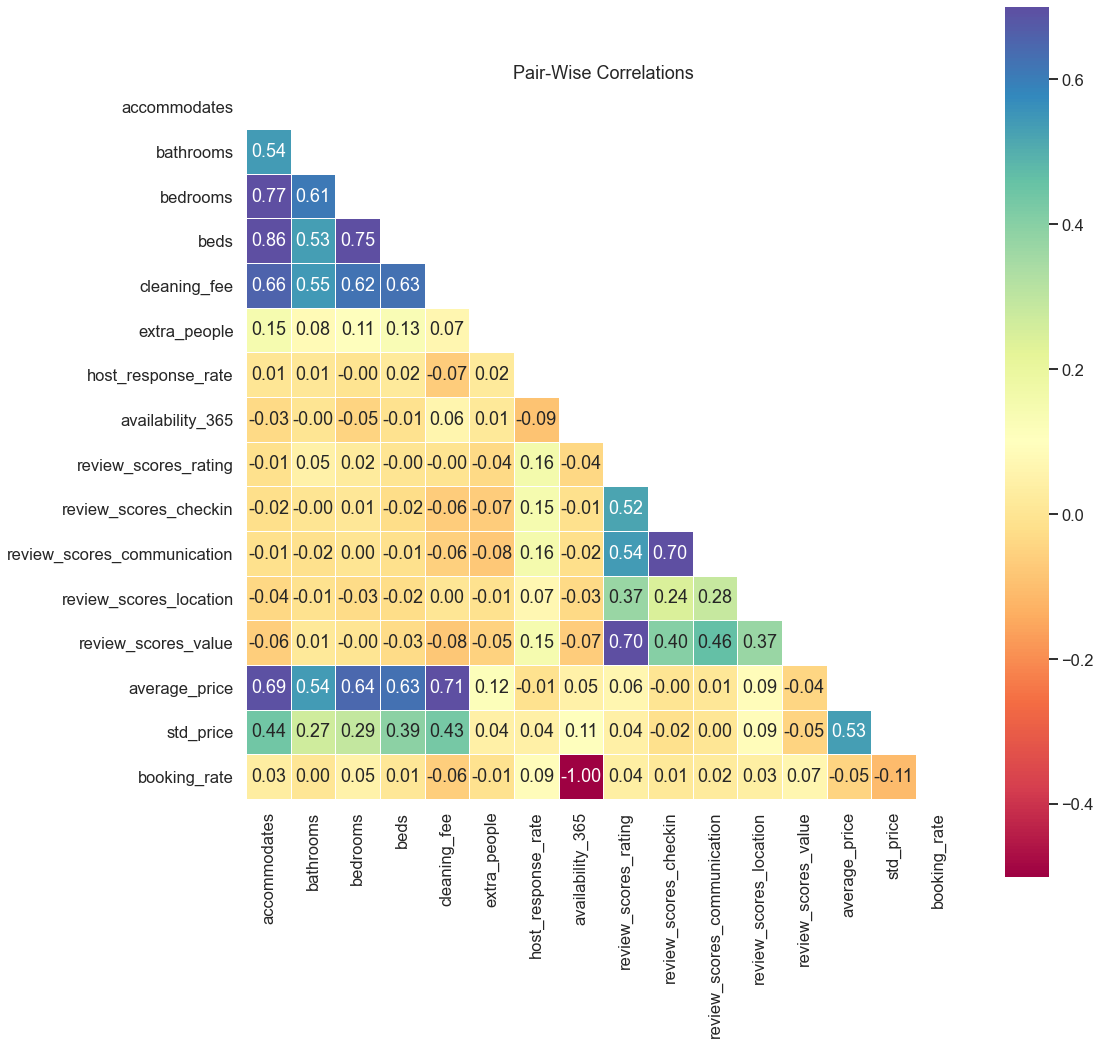

In [9]:
#Feature columns to calculate correlations on
colms = ['accommodates','bathrooms','bedrooms','beds',
        'cleaning_fee', 'extra_people','host_response_rate','availability_365',
        'review_scores_rating', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
         'review_scores_value','average_price','std_price','booking_rate',]
#combine average price and booking info with listing info
ave_price_df = calendar_df.groupby('listing_id')[['price','booked']].agg({'price':['mean', 'std'],'booked':'mean'}).reset_index()
ave_price_df.columns = ['listing_id','average_price','std_price','booking_rate']

all_df = pd.merge(listings_df, ave_price_df, how='left', left_on='id', right_on='listing_id')
all_df[['cleaning_fee','extra_people','host_response_rate']] = all_df[['cleaning_fee','extra_people','host_response_rate']].replace({'\$':'',',':'','\%':''}, regex = True).astype(float) #clean up "cleaning_fee" (hehe)

# set up heatmap of pair-wise correlations
corr = all_df[colms].astype(float).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

#plot heatmap of pair-wise correlations
plt.figure(figsize=(16,16))
ax4 = sns.heatmap(corr, mask=mask, linewidths=0.5, vmin=-0.5,vmax=0.7, square=True, cmap="Spectral", linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-Wise Correlations');
ax4.set_facecolor("white")


**Insights**

From the above heatmap we see that the price the market will bare for a particular property is strongly correlated with the number of bedrooms/beds/bathrooms and how many guest can be accomodated. There is also strong correlation between price and cleaning fee, as more expensive properties tend to charge more for cleaning. We see that cleaning fees weakly correlate to lower booking rates, but this can be offset ensure we maintain a rapid response time to guest queries. We also note that booking rates can be improved by improving our review score value as hosts, which is also sensitive to host response rate. 

**Location, Location, Location**

The final step of our EDA involes exploring the effect of location of listings on booking rate, nightly price and annual revenue. 

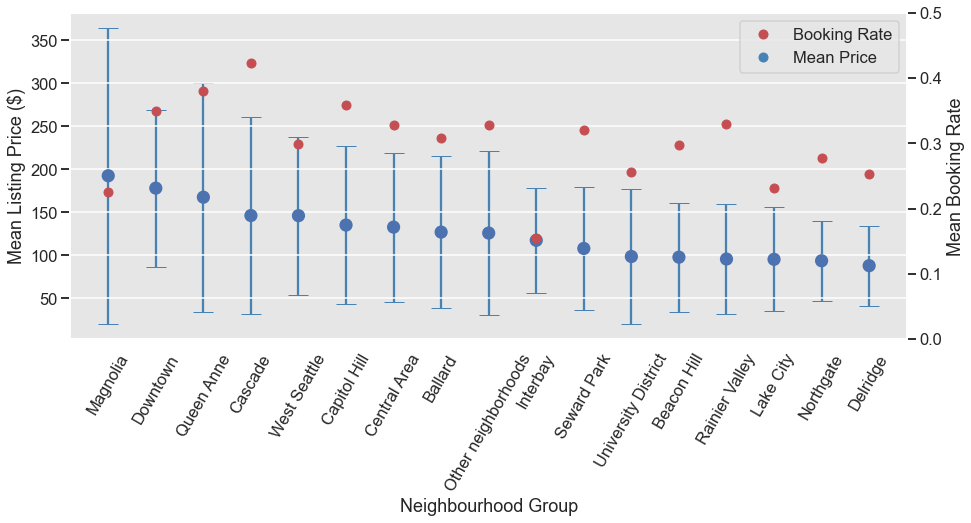

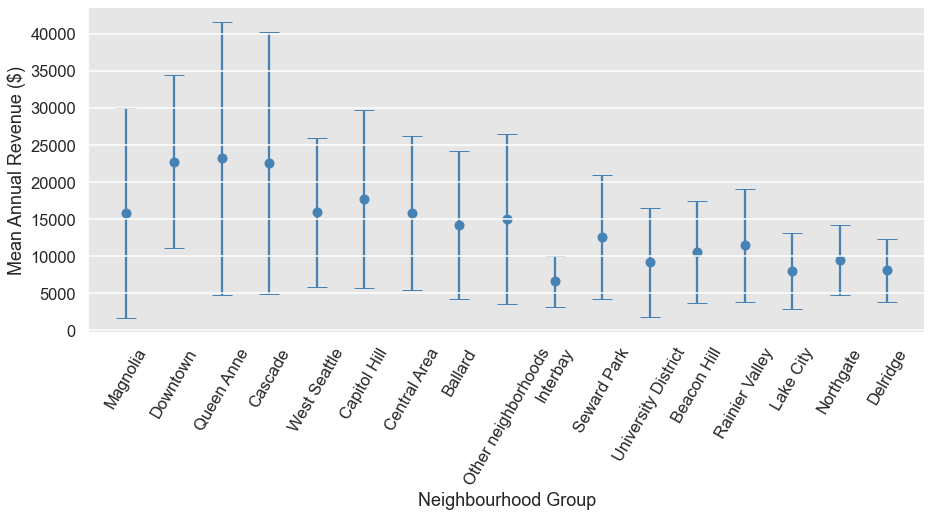

In [10]:
#find the mean, stand. dev. price and mean booking rate for each neighbourhood
hood_df = (all_df.groupby('neighbourhood_group_cleansed')[['average_price','booking_rate']]
           .agg({'average_price':['mean', 'std'],'booking_rate':'mean'}).reset_index())
hood_df.columns = ['neighbourhood','hood_mean_price','hood_std_price','hood_booking_rate']
hood_df.sort_values(by=['hood_mean_price'], inplace=True, ascending=False)

#plot mean prices
plt.figure(figsize = (15,6))
plt.xticks(rotation=60)
ax5 = sns.pointplot(x="neighbourhood", y="hood_mean_price", data=hood_df,join=False)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Mean Listing Price (\$)');

# Find the x,y coordinates for each point for errorbars
x_coords = []
y_coords = []
for point_pair in ax5.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax5.errorbar(x_coords, y_coords, yerr=hood_df['hood_std_price'], ecolor='steelblue', fmt=' ', zorder=-1,capsize=10)

#plot Booking Rate averages
ax6=ax5.twinx()
ax6.plot(hood_df['neighbourhood'],hood_df['hood_booking_rate'],'ro',label='Booking Rate')
ax6.set_ylabel('Mean Booking Rate')
ax6.grid(False)
plt.ylim(0,0.5)
ax6.plot([], [], 'o', color='steelblue', label = 'Mean Price') #dummy axis for legend
plt.legend(loc='best');

#plot annual revenue
plt.figure(figsize = (15,6))
plt.xticks(rotation=60)
plt.gca().xaxis.grid(False)
ax7=(plt.errorbar(hood_df['neighbourhood'],365*hood_df['hood_mean_price']
              .multiply(hood_df['hood_booking_rate']), yerr=365*hood_df['hood_booking_rate']
              .multiply(hood_df['hood_std_price']), ecolor='steelblue', fmt='o', zorder=-1,capsize=10,color='steelblue'));
plt.xlabel('Neighbourhood Group')
plt.ylabel('Mean Annual Revenue (\$)');

**Insights**:

- Magnolia, Downtown and Queen Anne anre the neighbourhood groups with the highest mean listing price, above \$150 a night 
- Northgate and Delridge are the cheapest, with a mean lisiting price below \$100 a night. 
- Cascade, Queen Anne and Capitol Hill have the highest mean booking rates at around 40% and Interbay and Magnolia the lowest at around 20%. 
- Hosts in Downtown, Queen Anne and Cascade have the highest annual turnovers around \$23k p.a. 
- Interbay, Lake City and Delridge have the lowest revenues, around \$7k p.a.  

**Build a Pricing and Expected Revenue Model**

In [11]:
#Prep data (one-hot encode, drop outliers, fill NaNs)
features = ['neighbourhood_group_cleansed','cleaning_fee','extra_people','beds', 'bathrooms','bedrooms', 'accommodates', 'room_type',
            'minimum_nights','cancellation_policy', 'require_guest_phone_verification', 'host_has_profile_pic',
           'review_scores_rating', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
            'review_scores_value','host_response_rate','average_price','booking_rate']

training_data_df = all_df.loc[:,features]

#clean up dataset
training_data_df['host_response_rate'].replace({'\%':''}, regex = True).astype(float)
training_data_df.dropna(axis=0, how='any', inplace=True)
training_data_df['host_has_profile_pic']=training_data_df['host_has_profile_pic'].map({'f':0,'t':1})
training_data_df['require_guest_phone_verification']=training_data_df['require_guest_phone_verification'].map({'f':0,'t':1})

#remove outliers
training_data_df = training_data_df[(np.abs(stats.zscore(training_data_df['booking_rate'])) < 2)] #within 2 std of mean booking rate

#one-hot encoding
training_data_df = (pd.get_dummies(training_data_df, columns=['neighbourhood_group_cleansed','room_type','cancellation_policy'],
                                   prefix=['Neighbourhood','room_type','cancellation_policy']))
training_data_df.head()

,cleaning_fee,extra_people,beds,bathrooms,bedrooms,accommodates,minimum_nights,require_guest_phone_verification,host_has_profile_pic,review_scores_rating,...,Neighbourhood_Rainier Valley,Neighbourhood_Seward Park,Neighbourhood_University District,Neighbourhood_West Seattle,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
1,40.0,0.0,1.0,1.0,1.0,4,2,1,1,96.0,...,0,0,0,0,1,0,0,0,0,1
2,300.0,25.0,7.0,4.5,5.0,11,4,0,1,97.0,...,0,0,0,0,1,0,0,0,0,1
4,125.0,15.0,3.0,2.0,3.0,6,1,0,1,92.0,...,0,0,0,0,1,0,0,0,0,1
7,25.0,0.0,1.0,1.0,1.0,2,2,1,1,97.0,...,0,0,0,0,0,1,0,0,0,1
9,40.0,0.0,1.0,1.0,1.0,4,2,1,1,97.0,...,0,0,0,0,1,0,0,0,0,1


In [12]:
#Test/Train Split
X = training_data_df.drop(columns = 'booking_rate')
BR = training_data_df['booking_rate']
X_train, X_test, BR_train, BR_test = train_test_split(X, BR, test_size = 0.2, random_state=2021)


In [13]:
price_model = (lgb.LGBMRegressor(num_leaves=32,max_depth=8,learning_rate=0.01,n_estimators=2048,min_child_samples=24,subsample=0.8,
                        subsample_freq=1,feature_fraction=0.8,reg_lambda=0.1,random_state=2021,n_jobs=2,metrics='mse'))

In [14]:
booking_rate_model = (lgb.LGBMRegressor(num_leaves=32,max_depth=8,learning_rate=0.015,n_estimators=5096,min_child_samples=24,subsample=0.8,
                        subsample_freq=1,feature_fraction=0.8,reg_lambda=0.1,random_state=2021,n_jobs=2,metrics='mse'))

In [15]:
# Training our model for annual revenue
print('booking rate model')
folds_n = 4

BR_feature_importance_df = pd.DataFrame()
kfolds = KFold(n_splits=folds_n, shuffle=True, random_state=2021)
for fold_, (train_idx, val_idx) in enumerate(kfolds.split(X_train.values, BR_train.values)):

    #training
    trn_data = X_train.iloc[train_idx]
    trn_label = BR_train.iloc[train_idx]
    
    #validating
    val_data = X_train.iloc[val_idx]
    val_label = BR_train.iloc[val_idx]
    
    #run grad-boosted decision tree
    booking_rate_model.fit(X=trn_data, y=trn_label,eval_set=[(trn_data, trn_label), (val_data, val_label)],verbose=512,
                     early_stopping_rounds=100)

    #predict test set 
    BR_test_predict = booking_rate_model.predict(X_test)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X.columns
    fold_importance_df["importance"] = booking_rate_model.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    
    score = mean_squared_error(BR_test_predict, BR_test)
    print('Training Hold-Out MSE Booking Rate score: %.5f' %score)
    fold_importance_df["MSE_score"] = score
    BR_feature_importance_df = pd.concat([BR_feature_importance_df, fold_importance_df], axis=0)
    

booking rate model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	training's l2: 0.0538368	valid_1's l2: 0.0821792
Training Hold-Out MSE Booking Rate score: 0.07235
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	training's l2: 0.0591191	valid_1's l2: 0.0837047
Training Hold-Out MSE Booking Rate score: 0.07605
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	training's l2: 0.0586199	valid_1's l2: 0.0846091
Training Hold-Out MSE Booking Rate score: 0.07530
[Li

<ipython-input-19-600599338e24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_features['normalized_importance'] = important_features['importance'].div(important_features['importance'].max())


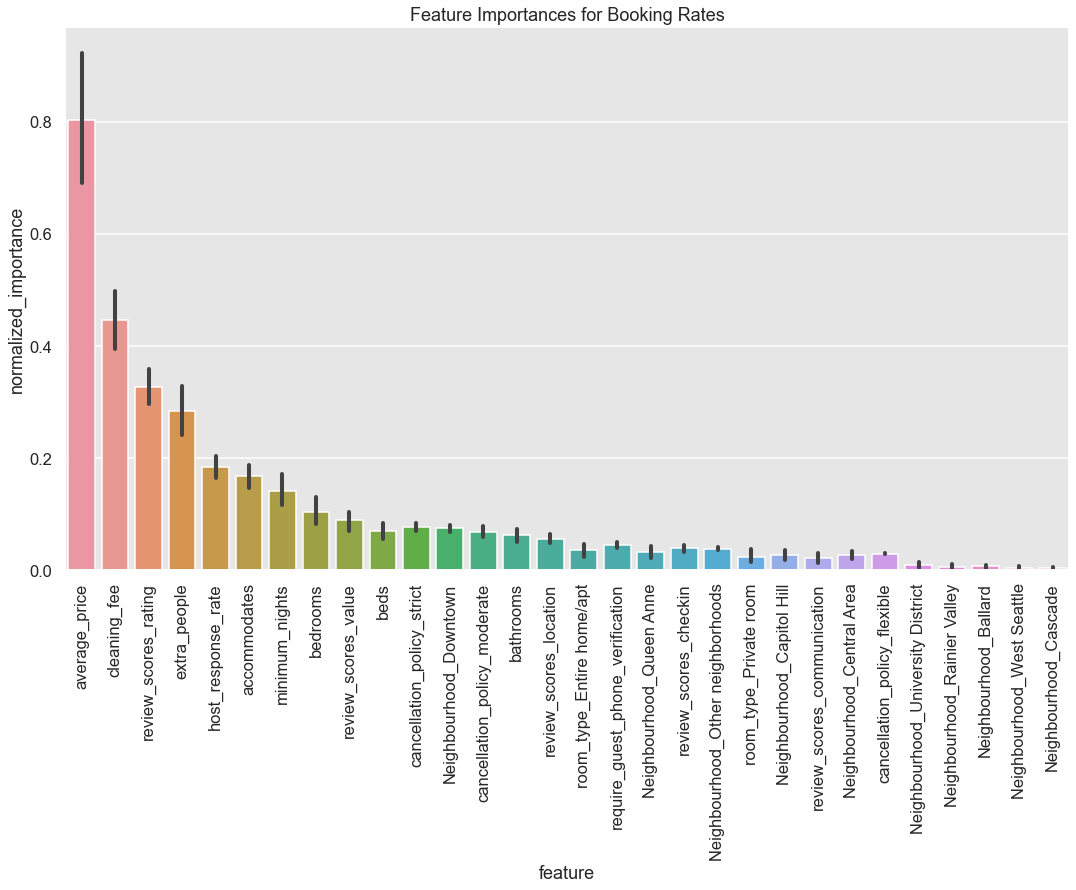

In [19]:
important_cols = (BR_feature_importance_df[['feature', 'importance']].groupby('feature').mean()
                  .sort_values(by='importance', ascending=False)[:30].index)

important_features = BR_feature_importance_df.loc[BR_feature_importance_df.feature.isin(important_cols)]
important_features['normalized_importance'] = important_features['importance'].div(important_features['importance'].max())

plt.figure(figsize=(18,10))
sns.barplot(x="feature",y='normalized_importance',data=important_features.sort_values(by='normalized_importance',ascending=False))

plt.title('Feature Importances for Booking Rates')
plt.xticks(rotation=90);

In [17]:
important_features

,feature,importance,fold,MSE_score,normalized_importance
0,cleaning_fee,880,1,0.072351,0.530440
1,extra_people,568,1,0.072351,0.342375
2,beds,150,1,0.072351,0.090416
3,bathrooms,106,1,0.072351,0.063894
4,bedrooms,235,1,0.072351,0.141652
...,...,...,...,...,...
33,room_type_Entire home/apt,69,4,0.073937,0.041591
34,room_type_Private room,70,4,0.073937,0.042194
36,cancellation_policy_flexible,50,4,0.073937,0.030139
37,cancellation_policy_moderate,119,4,0.073937,0.071730
